<a href="https://colab.research.google.com/github/alexander34ro/AML-Replicating-Novel-Deep-Learning-with-CNN-and-Bi-Directional-LSTM-for-Improved-Index-Prediction/blob/main/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# This is the dataset refrenced in the paper:
Yahoo Finance, S&P500 stock data [Online]. Available:
https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC.
[Accessed 29 Nov. 2018].


# This is the actual dataset based on the paper: https://finance.yahoo.com/quote/%5EGSPC/history?period1=1199232000&period2=1543276800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

# From 2008-01-02 to 2018-11-27


In [2]:
url = 'https://raw.githubusercontent.com/amir-souri/Stock-Market-Index-Prediction/master/GSPC.csv'
df = pd.read_csv(url, index_col='Date')

In [3]:
df.shape

(2747, 6)

In [4]:
df.tail(1) # last row

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-27,2663.75,2682.530029,2655.889893,2682.169922,2682.169922,3485220000


In [5]:
df.head(1) # first row

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,1467.969971,1471.77002,1442.069946,1447.160034,1447.160034,3452650000


In [6]:
df.dropna() # Drop all rows that might containe not available (na) values if any.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,1467.969971,1471.770020,1442.069946,1447.160034,1447.160034,3452650000
2008-01-03,1447.550049,1456.800049,1443.729980,1447.160034,1447.160034,3429500000
2008-01-04,1444.010010,1444.010010,1411.189941,1411.630005,1411.630005,4166000000
2008-01-07,1414.069946,1423.869995,1403.449951,1416.180054,1416.180054,4221260000
2008-01-08,1415.709961,1430.280029,1388.300049,1390.189941,1390.189941,4705390000
...,...,...,...,...,...,...
2018-11-20,2654.600098,2669.439941,2631.520020,2641.889893,2641.889893,4357900000
2018-11-21,2657.739990,2670.729980,2649.820068,2649.929932,2649.929932,3233550000
2018-11-23,2633.360107,2647.550049,2631.090088,2632.560059,2632.560059,1651650000


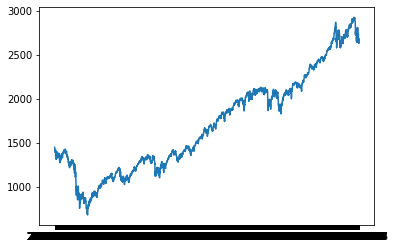

In [8]:
fig, ax = plt.subplots()
ax.plot(df["Close"]);